# Подбор параметров и обучение feature extractor

In [ ]:
!pip install unrar
!pip install --quiet optuna

import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import  DataLoader
import optuna
from optuna.samplers import RandomSampler
import torch.optim as optim
import seaborn as sns

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('data_and_model.py','wb').write(src)
from data_and_model import SiameseDataset, ValidationSiameseDataset, SiameseNet, TripletLoss

In [7]:
!unrar x /content/dataset.rar
x_train = np.load('/content/x_train_red.npy')
y_train = np.load('/content/y_train_red.npy')
x_val = np.load('/content/x_val_red.npy')
y_val = np.load('/content/y_val_red.npy')


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/dataset.rar

Extracting  x_train_red.npy                                               65% 78%  OK 
Extracting  x_val_red.npy                                                 97%  OK 
Extracting  y_test_red.npy                                                97%  OK 
Extracting  y_train_red.npy                                               97%  OK 
Extracting  y_val_red.npy                                                 97%  OK 
Extracting  x_test_red.npy                                               100%  OK 
All OK


In [8]:
def transformation(x): #add noise to spectra
  x = x/np.max(x)
  x = x + np.random.normal(0,0.005,x.shape[0])
  x = torch.Tensor(x)
  return x

In [9]:
train_dataset = SiameseDataset(x_train[2000:], y_train[2000:], transform = transformation)
val_dataset = ValidationSiameseDataset(x_val[500:], y_val[500:], transform = transformation)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [ ]:
def train(num_epochs, model, criterion_train, criterion_val, optimizer, train_loader, val_loader, latent_dim):
    loss_history = []
    l = []
    l_val = []
    n_p_train = []
    n_p_val = []

    for epoch in range(0, num_epochs):
      model.train()
      for i, batch in enumerate(train_loader, 0):
          anc, pos, neg = batch
          output_anc, output_pos, output_neg = model(anc.to(device), pos.to(device), neg.to(device), latent_dim)
          loss, number_pos = criterion_train(output_anc, output_pos, output_neg)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          l.append(loss.item())
          n_p_train.append(number_pos.item())

      model.eval()
      for i, batch in enumerate(val_loader, 0):
          anc, pos, neg = batch
          output_anc, output_pos, output_neg = model(anc.to(device), pos.to(device), neg.to(device), latent_dim)
          loss_val, number_pos_val = criterion_val(output_anc, output_pos, output_neg)
          l_val.append(loss_val.item())
          n_p_val.append(number_pos_val.item())
      scheduler.step()
      last_epoch_loss =  torch.tensor(l[-len(train_loader):-1]).mean()
      last_epoch_val_loss = torch.tensor(l_val[-len(val_loader):-1]).mean()
      print("Epoch {} with {:.4f} loss and {:.4f} val_loss".format(epoch, last_epoch_loss, last_epoch_val_loss))

    return l, last_epoch_loss, l_val, last_epoch_val_loss, n_p_train, n_p_val

In [ ]:
# define function which will optimized
def objective(trial):
    # boundaries for the optimizer's
    lr = trial.suggest_float("lr", 1e-5, 1e-2)
    latent_dim = trial.suggest_int("latent_dim", 8, 64, step=8)
    semi_hard = 0.5

    # create new model(and all parameters) every iteration
    model = SiameseNet(latent_dim).to(device)
    criterion_train = TripletLoss(margin = 1, semi_hard = semi_hard)
    criterion_val = TripletLoss(margin = 1, semi_hard = semi_hard)
    optimizer = optim.AdamW(
        model.parameters(), lr=lr
    )  # learning step regulates by optuna

    # To save time, we will take only 4 epochs
    train_loader = DataLoader(train_dataset, num_workers=2, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset,  num_workers=2, batch_size=128, shuffle=False)
    l, _, l_val, __, n_p_train, n_p_val = train(4, model, criterion_train, criterion_val, optimizer, train_loader, val_loader, latent_dim)
    return np.array(n_p_val).reshape(4, 16)[-1].mean()

# Create "exploration"
study = optuna.create_study(direction="minimize", study_name="Optimizer", sampler=RandomSampler(42))

study.optimize(
    objective, n_trials=20
)  # The more iterations, the higher the chances of catching the most optimal hyperparameters

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
latent_dim = 64
model = SiameseNet(latent_dim).to(device)
criterion_train = TripletLoss(margin = 1, semi_hard = 0.5)
criterion_val = TripletLoss(margin = 1, semi_hard = 0.5)

optimizer = optim.AdamW(model.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,8,12,16], gamma=0.5)
num_epochs = 20
l, _, l_val, __, n_p_train, n_p_val = train(num_epochs, model, criterion_train, criterion_val, optimizer, train_loader, val_loader, latent_dim)

Epoch 0 with 0.7349 loss and 0.7084 val_loss
Epoch 1 with 0.7072 loss and 0.7068 val_loss
Epoch 2 with 0.7045 loss and 0.6939 val_loss
Epoch 3 with 0.7006 loss and 0.6980 val_loss
Epoch 4 with 0.6970 loss and 0.6936 val_loss
Epoch 5 with 0.6996 loss and 0.6967 val_loss
Epoch 6 with 0.6965 loss and 0.7012 val_loss
Epoch 7 with 0.6939 loss and 0.6887 val_loss
Epoch 8 with 0.6946 loss and 0.6976 val_loss
Epoch 9 with 0.6896 loss and 0.6971 val_loss
Epoch 10 with 0.6940 loss and 0.6908 val_loss
Epoch 11 with 0.6918 loss and 0.7033 val_loss
Epoch 12 with 0.6914 loss and 0.6888 val_loss
Epoch 13 with 0.6955 loss and 0.6912 val_loss
Epoch 14 with 0.6940 loss and 0.6922 val_loss
Epoch 15 with 0.6923 loss and 0.6849 val_loss
Epoch 16 with 0.6932 loss and 0.6948 val_loss
Epoch 17 with 0.6892 loss and 0.6969 val_loss
Epoch 18 with 0.6932 loss and 0.6891 val_loss
Epoch 19 with 0.6926 loss and 0.6884 val_loss


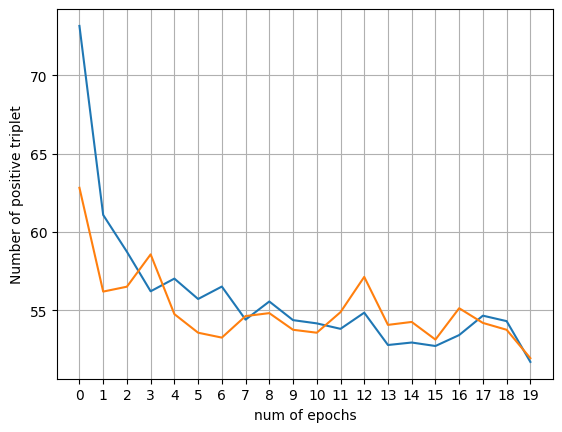

In [ ]:
n_p_plot_val = np.array(n_p_val).reshape(20, 16).mean(1)
n_p_plot_train = np.array(n_p_train).reshape(20, 63).mean(1)
plt.plot([i for i in range(len(n_p_plot_val))], n_p_plot_train, n_p_plot_val)
plt.ylabel('Number of positive triplet')
plt.xlabel('num of epochs')
x = range(0, len(n_p_plot_val), len(n_p_plot_val) // num_epochs)
labels = range(0, num_epochs)
plt.xticks(x, labels)
plt.grid()
plt.show()

In [ ]:
def validate(model, val_loader, latent_dim):
    distances_pos = []
    distances_neg = []
    model.eval()

    for i, batch in enumerate(val_loader, 0):
        anc, pos, neg = batch
        output_anc, output_pos, output_neg = model(anc.to(device), pos.to(device), neg.to(device), latent_dim)

        distance_pos = F.pairwise_distance(output_anc, output_pos).detach().cpu()
        distance_neg = F.pairwise_distance(output_anc, output_neg).detach().cpu()



        distances_pos.append(distance_pos)
        distances_neg.append(distance_neg)

    return distances_pos, distances_neg

In [ ]:
d_pos, d_neg = validate(model, val_loader, latent_dim = 64)

In [ ]:
pos_dist = []
neg_dist = []
for d in d_pos:
  d = d.detach().cpu().numpy()
  pos_dist.append(d)
for d in d_neg:
  d = d.detach().cpu().numpy()
  neg_dist.append(d)

neg_dist = np.concatenate(np.array(neg_dist), axis=0, dtype = object)
pos_dist = np.concatenate(np.array(pos_dist), axis=0, dtype = object )

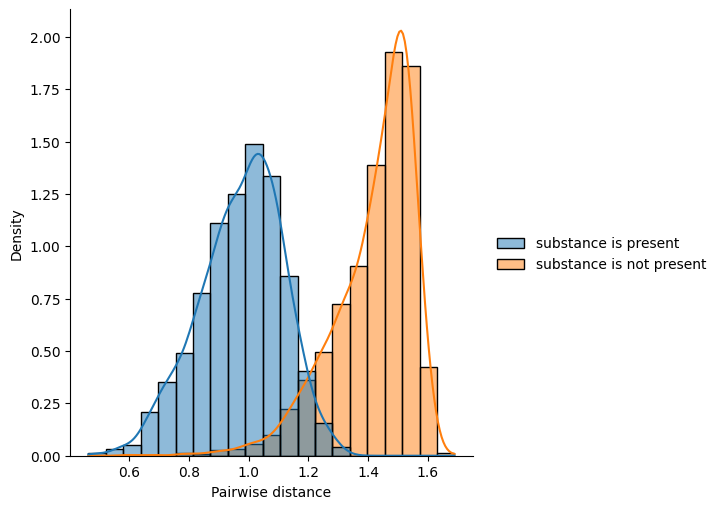

In [ ]:
distances = {"substance is present": pos_dist, "substance is not present": neg_dist}

ax = sns.displot(distances, kde=True, stat="density")
ax.set(xlabel="Pairwise distance")
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/model_weights')